In [1]:
# on-set = { 011 }, n_iteration = 2
# f = (x1)'(x1'x2')'(x2x3')' = (x1')(x1+x2)(x2'+x3)
from qiskit import *
from qiskit.quantum_info.operators import *
import numpy as np
%matplotlib inline

# num of anci_bits >= num of control_bits - 2
def MCT(qc, control_bits, target_bit, anci_bits):
    anci_idx = 0
    qc.ccx(control_bits[0], control_bits[1], anci_bits[anci_idx])
    for idx in range(2, len(control_bits) - 1):
        qc.ccx(control_bits[idx], anci_bits[anci_idx], anci_bits[anci_idx + 1])
        anci_idx += 1
    qc.ccx(control_bits[len(control_bits) - 1], anci_bits[anci_idx], target_bit)
    for idx in reversed(range(2, len(control_bits) - 1)):
        qc.ccx(control_bits[idx], anci_bits[anci_idx - 1], anci_bits[anci_idx])
        anci_idx -= 1
    qc.ccx(control_bits[0], control_bits[1], anci_bits[anci_idx])

def initialize(cir):
    cir.x(1)
    cir.x(2)
    cir.x(3)
    cir.h(1)
    cir.h(2)
    cir.h(3)

def oracle(cir):
    # computation
    cir.cx(1, 4) # clause C1'= (x1)
    cir.x(1)
    cir.x(2)
    cir.ccx(1, 2, 5) # clause C2'= (x1'x2')
    cir.x(2)
    cir.x(3)
    cir.ccx(2, 3, 6) # clause C3'= (x2x3')
    cir.x(4) # C1
    cir.x(5) # C2
    cir.x(6) # C3
    MCT(cir, range(4, 7), 0, range(7, 8)) # f = C1^C2^C3
    cir.z(0)
    # uncomputation
    MCT(cir, range(4, 7), 0, range(7, 8))
    cir.x(4)
    cir.x(5)
    cir.x(6)
    cir.ccx(2, 3, 6)
    cir.x(2)
    cir.x(3)
    cir.ccx(1, 2, 5)
    cir.x(1)
    cir.x(2)
    cir.cx(1, 4)

def diffusion(cir):
    cir.h(1)
    cir.h(2)
    cir.ccx(1, 2, 3)
    cir.h(1)
    cir.h(2)

n_iterations = 2
cir = QuantumCircuit(8, 3) # 0: result qubit, 1~3: vars, 4~6: clauses, 7: mct ancillary
initialize(cir)
for i in range(n_iterations):
    oracle(cir)
    diffusion(cir)

cir.barrier(range(1, 4))
cir.measure(range(1, 4), range(0, 3))
cir.draw()

{'000': 4, '001': 6, '010': 5, '110': 983, '111': 4, '101': 8, '100': 7, '011': 7}


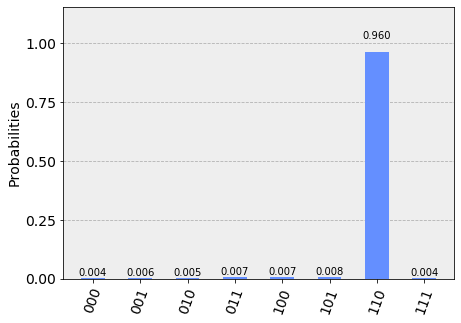

In [5]:
simulator = Aer.get_backend('qasm_simulator')
job = execute(cir, simulator, shots = 1024)
result = job.result()

counts = result.get_counts(cir)
print(counts)
visualization.plot_histogram(counts)